![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

# Research to Production
## Sparse Optimization Index Tracking
---------
### Introduction
This notebook explains how to you can use the Research Environment to develop and test a Sparse Optimization Index Tracking hypothesis, then put the hypothesis in production.

<a href="https://www.quantconnect.com/docs/v2/research-environment/tutorials/research-to-production/sparse-optimization-index-tracking">Documentation</a>

### Create Hypothesis
<p>Passive index fund portfolio managers will buy in corresponding weighting of stocks from an index's constituents. The main idea is allowing market participants to trade an index in a smaller cost. Their performance is measured by Tracking Error (TE), which is the standard deviation of the active return of the portfolio versus its benchmark index. The lower the TE means that the portfolio tracks the index very accurately and consistently.</p>

<p>A technique called Sparse Optimization comes into the screen as the portfolio managers want to cut their cost even lower by trading less frequently and with more liquid stocks. They select a desired group/all constituents from an index and try to strike a balance between the number of stocks in the portfolio and the TE, like the idea of L1/L2-normalization.</p>

<p>On the other hand, long-only active fund aimed to beat the benchmark index. Their performance are measured by the mean-adjusted tracking error, which also take the mean active return into account, so the better fund can be identified as consisitently beating the index by n%.</p>

<p>We can combine the 2 ideas. In this tutorial, we are about to generate our own active fund and try to use Sparse Optimization to beat QQQ. However, we need a new measure on active fund for this technique -- Downward Risk (DR). This is a measure just like the tracking error, but taking out the downward period of the index, i.e. we only want to model the index's upward return, but not downward loss. We would also, for a more robust regression, combining Huber function as our loss function. This is known as Huber Downward Risk (HDR). Please refer to <a href="https://palomar.home.ece.ust.hk/papers/2018/BenidisFengPalomar-FnT2018.pdf">Optimization Methods for Financial Index Tracking: From Theory to Practice. <i>K. Benidis, Y. Feng, D. P. Palomer (2018)</i></a> for technical details.</p>

### Prerequisites
You must understand how to work with pandas DataFrames and Series. If you are not familiar with pandas, refer to the <a href="https://pandas.pydata.org/docs/">pandas documentation</a>.

### Import Libraries
We'll need to import packages to help with data processing, model building, validation and visualization. Import arch, pykalman, scipy, statsmodels, numpy, matplotlib and pandas packages by the following:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Get Historical Data
To begin, we retrieve historical data for research.

In [2]:
# Create a class to get the ETF constituents on a particular date.

class ETFUniverse:
    """
    A class to create a universe of equities from the constituents of an ETF
    """
    def __init__(self, etf_ticker, universe_date):
        """
        Input:
         - etf_ticker
            Ticker of the ETF
         - universe_date
            The date to gather the constituents of the ETF
        """
        self.etf_ticker = etf_ticker
        self.universe_date = universe_date
    
    
    def get_symbols(self, qb):
        """
        Subscribes to the universe constituents and returns a list of symbols and their timezone
        
        Input:
         - qb
            The QuantBook instance inside the DatasetAnalyzer
        
        Returns a list of symbols and their timezone
        """
        etf_symbols = self._get_etf_constituents(qb, self.etf_ticker, self.universe_date)
        security_timezone = None
        security_symbols = []
        
        # Subscribe to the universe price data
        for symbol in etf_symbols:
            security = qb.AddSecurity(symbol, Resolution.Daily)
            security_timezone = security.Exchange.TimeZone
            security_symbols.append(symbol)
        
        return security_symbols, security_timezone
    
    
    def _get_etf_constituents(self, qb, etf_ticker, date):
        """
        A helper method to retreive the ETF constituents on a given date
        
        Input:
         - qb
            The QuantBook instance inside the DatasetAnalyzer
         - etf_ticker
             Ticker of the ETF
         - universe_date
            The date to gather the constituents of the ETF
        
        Returns a list of symbols
        """
        date_str = date.strftime("%Y%m%d")
        filename = f"/data/equity/usa/universes/etf/{etf_ticker.lower()}/{date_str}.csv"
        try:
            df = pd.read_csv(filename)
        except:
            print(f'Error: The ETF universe file does not exist')
            return
        security_ids = df[df.columns[1]].values
        symbols = [qb.Symbol(security_id) for security_id in security_ids]
        return symbols

In [3]:
# Instantiate a QuantBook.
qb = QuantBook()

# Subscribe to the index/ETF.
qqq = qb.AddEquity("QQQ").Symbol

# Select all the constituents for research.
# In this tutorial, we select the constituents of QQQ on 2020-12-31.
assets, _ = ETFUniverse("QQQ", datetime(2020, 12, 31)).get_symbols(qb)

# Prepare the historical return data of the constituents and the ETF (as index to track).
history = qb.History(assets, datetime(2020, 1, 1), datetime(2021, 3, 31), Resolution.Daily)
historyPortfolio = history.close.unstack(0).loc[:"2021-01-01"]
pctChangePortfolio = np.log(historyPortfolio/historyPortfolio.shift(1)).dropna()

historyQQQ_ = qb.History(qqq, datetime(2020, 1, 1), datetime(2021, 3, 31), Resolution.Daily)
historyQQQ = historyQQQ_.close.unstack(0).loc[:"2021-01-01"]
pctChangeQQQ = np.log(historyQQQ/historyQQQ.shift(1)).loc[pctChangePortfolio.index]

### Prepare Data
We'll construct the proposed sparse index tracking portfolio.

In [4]:
# Get the dimensional sizes.
m = pctChangePortfolio.shape[0]; n = pctChangePortfolio.shape[1]

# Set up optimization parameters (penalty of exceeding bounds, Huber statistics M-value, penalty weight).
p = 0.5; M = 0.0001; l = 0.01

# Set up convergence tolerance, maximum iteration of optimization, iteration counter and HDR as minimization indicator.
tol = 0.001; maxIter = 20; iters = 1; hdr = 10000

# Initial weightings and placeholders.
w_ = np.array([1/n] * n).reshape(n, 1)
weights = pd.Series()
a = np.array([None] * m).reshape(m, 1)
c = np.array([None] * m).reshape(m, 1)
d = np.array([None] * n).reshape(n, 1)

# Iterate to minimize the HDR.
while iters < maxIter:
    x_k = (pctChangeQQQ.values - pctChangePortfolio.values @ w_)
    for i in range(n):
        w = w_[i]
        d[i] = d_ = 1/(np.log(1+l/p)*(p+w))
    for i in range(m):
        xk = float(x_k[i])
        if xk < 0:
            a[i] = M / (M - 2*xk)
            c[i] = xk
        else:
            c[i] = 0
            if 0 <= xk <= M:
                a[i] = 1
            else:
                a[i] = M/abs(xk)

    L3 = 1/m * pctChangePortfolio.T.values @ np.diagflat(a.T) @ pctChangePortfolio.values
    eigVal, eigVec = np.linalg.eig(L3.astype(float))
    eigVal = np.real(eigVal); eigVec = np.real(eigVec)
    q3 = 1/max(eigVal) * (2 * (L3 - max(eigVal) * np.eye(n)) @ w_ + eigVec @ d - 2/m * pctChangePortfolio.T.values @ np.diagflat(a.T) @ (c - pctChangeQQQ.values))
    
    # We want to keep the upper bound of each asset to be 0.1
    u = 0.1
    mu = float(-(np.sum(q3) + 2)/n); mu_ = 0
    while mu > mu_:
        mu = mu_
        index1 = [i for i, q in enumerate(q3) if mu + q < -u*2]
        index2 = [i for i, q in enumerate(q3) if -u*2 < mu + q < 0]
        mu_ = float(-(np.sum([q3[i] for i in index2]) + 2 - len(index1)*u*2)/len(index2))

    # Obtain the weights and HDR of this iteration.
    w_ = np.amax(np.concatenate((-(mu + q3)/2, u*np.ones((n, 1))), axis=1), axis=1).reshape(-1, 1)
    w_ = w_/np.sum(abs(w_))
    hdr_ = float(w_.T @ w_ + q3.T @ w_)

    # If the HDR converges, we take the current weights
    if abs(hdr - hdr_) < tol:
        break

    # Else, we would increase the iteration count and use the current weights for the next iteration.
    iters += 1
    hdr = hdr_

for i in range(n):
    weights[pctChangePortfolio.columns[i]] = w_[i]

# Get the historical return of the proposed portfolio.
histPort = historyPortfolio.dropna() @ np.array([weights[pctChangePortfolio.columns[i]] for i in range(pctChangePortfolio.shape[1])])
histPort

/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars


,0
time,
2020-07-01,233.517
2020-07-02,237.955
2020-07-03,239.675
2020-07-07,246.514
2020-07-08,244.001
...,...
2020-12-25,297.386
2020-12-29,300.15
2020-12-30,300.579


### Test the Hypothesis
To test the hypothesis. We wish to (1) outcompete the benchmark and (2) the active return is consistent in the in- and out-of-sample period.

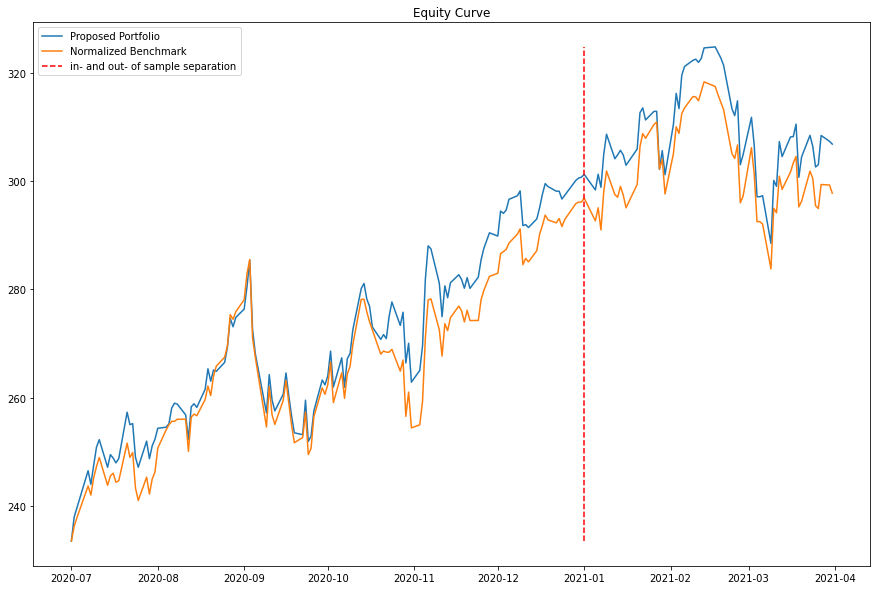

<Figure size 432x288 with 0 Axes>

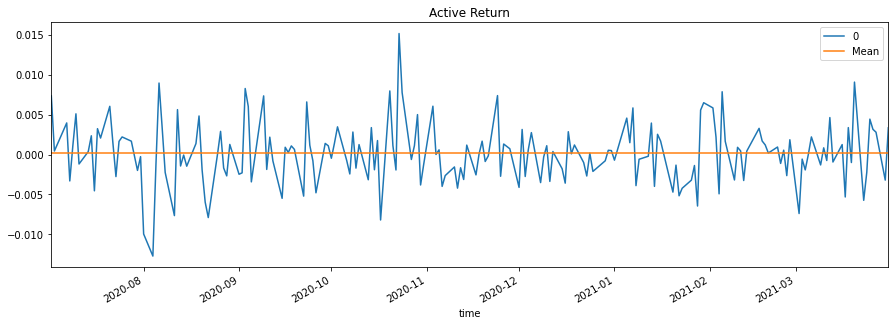

In [5]:
# Obtain the equity curve of our portfolio and normalized benchmark for comparison.
proposed = history.close.unstack(0).dropna() @ np.array([weights[pctChangePortfolio.columns[i]] for i in range(pctChangePortfolio.shape[1])])
benchmark = historyQQQ_.close.unstack(0).loc[proposed.index]
normalized_benchmark = benchmark / (float(benchmark.iloc[0])/float(proposed.iloc[0]))

# Obtain the active return.
proposed_ret = proposed.pct_change().iloc[1:]
benchmark_ret = benchmark.pct_change().iloc[1:]
active_ret = proposed_ret - benchmark_ret.values

# Plot the result.
fig = plt.figure(figsize=(15, 10))
plt.plot(proposed, label="Proposed Portfolio")
plt.plot(normalized_benchmark, label="Normalized Benchmark")
min_ = min(min(proposed.values), min(normalized_benchmark.values))
max_ = max(max(proposed.values), max(normalized_benchmark.values))
plt.plot([pd.to_datetime("2021-01-01")]*100, np.linspace(min_, max_, 100), "r--", label="in- and out- of sample separation")
plt.title("Equity Curve")
plt.legend()
plt.show()
plt.clf()

fig, ax = plt.subplots(1, 1)
active_ret["Mean"] = float(active_ret.mean())
active_ret.plot(figsize=(15, 5), title="Active Return", ax=ax)
plt.show()

We can see from the plots, both in- and out-of-sample period the proposed portfolio out preform the benchmark while remaining a high correlation with it. Although the active return might not be very consistent, but it is a stationary series above zero. So, in a long run, it does consistently outcompete the QQQ benchmark!

### Reference
<ul>
    <li>Optimization Methods for Financial Index Tracking: From Theory to Practice. K. Benidis, Y. Feng, D. P. Palomer (2018). <i>Foundations and Trends in Signal Processing. 3-3.</i> p171-279.</li>
</ul>